In [1]:
import numpy as np
from nm_lib import nm_lib as nm
import threading

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Riemann scheme. 

Lets consider same setup as in [ex_3a](https://github.com/AST-Course/AST5110/blob/main/ex_3a.ipynb) Burgers’ equation, i.e.,

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0   \tag{1}$$ 

for the domain $x \in (x_0, x_f)$ with $x_0 = −1.4$, $x_f = 2.0$ with initial condition:

$$u(x,t=0) = A\left[\tanh\left(\frac{x+x_c}{W}\right)-\tanh\left(\frac{x-x_c}{W}\right)\right]   \tag{2}$$

whereby $A = 0.02$ , $x_c = 0.70$, $W = 0.1$. Let the solution evolve until time $t_f = 100$. However, let's now implement a new time-step method. Find the conservative form of the equation and implement a Rieman solver [wiki:Rieman Solvers](https://github.com/AST-Course/AST5110/wiki/Riemann-solvers). 

Add this to your library and solve the previous simulation imposing the CFL condition. For this exercise, fill in `nm_lib` the function `evolv_Rie_uadv_burgers`. 

In [2]:
def u(x, A, W, xc):
    return A * (np.tanh((x+xc)/W) - np.tanh((x-xc)/W))

A = 0.02
xc = 0.70
W = 0.1
nt= 100

x0 = -1.4
xf = 2.0
#number of x-points
nump = 256
#number of t-points
nt = 100
#xgrid
xx = np.arange(nump)/(nump-1.0) * (xf-x0) + x0
hh = u(xx, A, W, xc)

#### 1 step

Compute left and right of $u$, i.e., $u_L$ and $u_R$. Note that $u_R = u_{i+1}$ and $u_L = u_i$

#### 2 step
Rewrite the eq 1 in a conservative form to get the Flux. Compute from the left and right variable ($u_L$ and $u_R$) the corresponding flux, i.e., $F_L$ and $F_R$

We first note that
$$
\frac{\partial u^2}{\partial x} = 2u\frac{\partial u}{\partial x}.
$$

We use this in eq 1 to get the conservative form
$$
\frac{\partial u}{\partial t} +\frac{\partial \frac{1}{2}u^2}{\partial x}=0.
$$


We then see from this equation that the flux is
$$
F(u) = \frac{1}{2}u^2.
$$

#### 3 step
Compute the propagating speed. This will be the derivatie of the flux with respect to variable $u$ in absolute values and select the largest between the left and right shells ($v_a$).

#### 4 step
Compute the interface fluxes (Rusanov)

$F^*_{i+1/2}=\frac{F_R+F_L}{2} - \frac{v_a}{2} (U_R -U_L)$

Note that $F^*_{i+1/2}$ is half grid shifted

#### 5 step
Advance in time $u^{n+1}=u^n - dt\times (F^*_{i+1/2}-F^*_{i-1/2})$. 

What is dt taking into account the phase speed ($v_a$)? 


dt is taking into account the propagation speed.

Is this method less or more diffusive than Lax method? Find the analytical solution and compare. Where and when is better or worse than the Lax method? 

The different approximations of Rieman solvers uses different ways to estimate $F^*$ and phase velocity ($v_a$). Otherwise they do the same steps. 

**Analytical solution**

This is a Cauchy problem and we can solve it using the method of characteristics. To do this we note that

$$
\frac{du(x(t),t)}{ds}=\partial u_t +u \partial u_x = 0.
$$

In other words $u$ is constant along a line $(x(s), t(s))$. We use this and get a system of ODEs:

$$
\frac{dt}{ds} = 1,
$$

$$
\frac{dx}{ds}=u,
$$

$$
\frac{du}{ds}=0.
$$

The first equation gives us that $t-t_0=s-s_0$ and we set $t(0)=t_0=0$ so that $s=t$. Integrating the second equation gives us that 

$$x-x_0 = us \Leftrightarrow x(s)=x_0 + us.$$

And the third equation shows that $u(s)=u(t)=constant$, and we therefore use $s_0=t_0=0$ to get that $u(s_0=0)=\phi(x(0))$, where $\phi(x)$ is the inital condition. It is then easy to see that $u(0)=\phi(x_0)$ and since this is constant we get that 

$$u(t)=\phi(x_0)=\phi(x(t)-ut).$$

In [42]:
#Riemann solution
tt, unnt = nm.evolv_Rie_uadv_burgers(xx, hh, nt, cfl_cut = 0.98)

### I have not used shift_xx. Do I need to shift the grid for the analytical solution?

In [54]:
def shift_xx(xx, a, t, xf, x0):
    #let x-grid move with velocity a to the side and wrap around to other side
    #takes in the velocity a and the current time t. And end of grid xf and start x0
    xx_new = ((xx - a * t) - x0) % (xf - x0) + x0
    return xx_new

In [63]:
#analytical solution
#X = np.zeros((len(tt), len(xx)))

unnta = np.zeros((len(tt),len(xx)))
unnta[0,:] = hh
for i in range(1, len(tt)):
    #X[i, :] = shift_xx(xx, unnta[i-1,:], tt[i], xf, x0)
    x_0 = xx - unnta[i-1,:] * t
    unnta[i,:] = u(x_0, A, W, xc) 

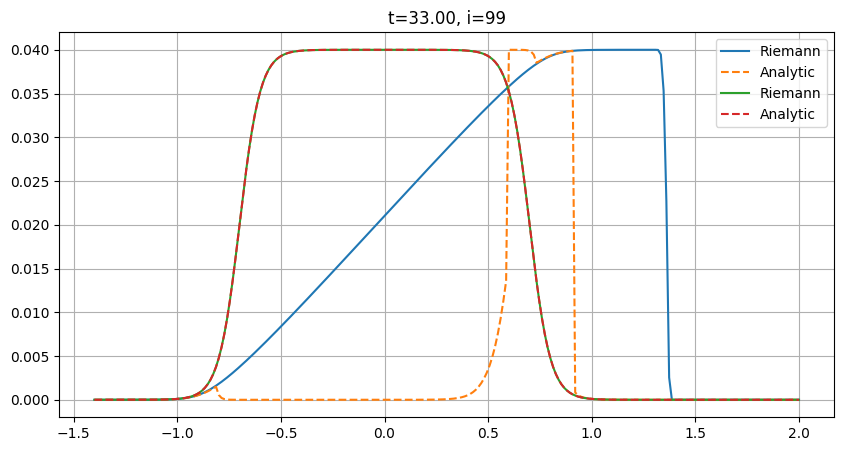

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

def init(): 
    axes.plot(xx,unnt[0,:], label="Riemann")
    axes.plot(xx,unnta[0,:], label="Analytic", linestyle="--")
    axes.legend()
    #axes.set_ylim(-0.05, 1.05)
    axes.grid(True)
    
def animate(i):
    axes.clear()
    axes.plot(xx,unnt[i,:], label="Riemann")
    axes.plot(xx,unnta[i,:], label="Analytic",linestyle="--")
    axes.set_title('t={:.2f}, i={:g}'.format(tt[i],i))
    axes.grid(True)
    axes.legend()
    #axes.set_ylim(-0.05, 1.05)

anim = FuncAnimation(fig, animate, interval=50, frames=nt, init_func=init)
HTML(anim.to_jshtml())

---
## TVD scheme. 

Combine the Lax method with the Rieman solver using a flux limiter scheme. For this, one needs to identify how large are the gradients. Lets define: 

$$r^{+}_i = \frac{u_i-u_{i-1}}{u_{i+1}+u_i}$$

What kind of properties do you see on $r^{+}_i$? e.g., what happens when $r\ge0$? or $r\le0$? 

now lets consider the following flux limiter: 

$$\phi = max\left(0,min\left(\theta r,\frac{1+r}{2},\theta \right)\right),\, \theta =[1,2]$$

Finally, combine the Lax from previous excersice with the Riemann solver using the flux limiter as follows: 

$$u^{n+1}_i = u^n_i + dt (f^n_{i+1/2}-f^n_{i-1/2})$$

Where 

$$f^n_{i+1/2} = f^{Riemann}_{i+1/2} + \phi^n_i (f^{L}_{i+1/2}-f^{Riemann}_{i+1/2})$$



When becomes purely Rieman solver? And Lax? Which others methods you can find depending on what is $r$ of $\phi$. 

What would be the corrective numerical flux in order to be a flux-limited?